## Задачи сегментации фасадов и детекции объектов (окна, колонны)

#### Необходимо обучить собственный алгоритм tensorflow сегментации фасада главного здания, а также алгоритм определения числа окон и числа колонн.
#### Заказчик хотел бы выделять на фото фасад "главного" здания, если на изображении несколько зданий.

Решение задачи требует создания нескольких алгоритмов машинного обучения для решения трех различных задач:

* Сегментация фасада главного здания на изображении
* Определение числа окон на фасаде
* Определение числа колонн на фасаде

Для решения каждой из этих задач можно использовать различные алгоритмы машинного обучения, такие как нейронные сети и алгоритмы компьютерного зрения.

Например, для **сегментации фасада главного здания на изображении можно использовать алгоритмы семантической сегментации**, такие как FCN, U-Net или SegNet, которые могут обучаться на размеченных данных, где каждый пиксель на изображении помечен как принадлежащий к фасаду или нет.

Для **определения числа окон и числа колонн на фасаде можно использовать алгоритмы детектирования объектов**, такие как Faster R-CNN, RetinaNet или YOLO, которые могут обучаться на размеченных данных, где каждый объект (окно или колонна) на изображении помечен с помощью ограничивающей рамки.

Также можно использовать готовые модели машинного обучения, предварительно обученные на больших наборах данных, такие как ImageNet, и дообучать их на своих размеченных данных.

Однако, чтобы создать алгоритмы машинного обучения для решения этих задач, необходимо иметь доступ к размеченным данным, то есть набору изображений, на которых фасады главного здания помечены, а также размечены окна и колонны. Такие данные были получены на первом этапе предобработки данных путем ручной разметки изображений.

Кроме того, необходимо провести оценку качества полученных моделей машинного обучения на тестовых данных, чтобы убедиться в их эффективности и точности. Для этого можно использовать метрики, такие как точность, полноту и F1-меру, а также визуально сравнить результаты работы модели с оригинальными изображениями.

Кроме того, стоит учитывать, что **задача определения числа окон и колонн на фасаде может быть достаточно сложной, особенно если на изображении находятся объекты разных размеров, расположенные на разном расстоянии от камеры, в разных условиях освещения и т.д. Поэтому для получения точных результатов может потребоваться использование дополнительных методов предобработки изображений, таких как поворот, масштабирование и улучшение контрастности.**

*Для обучения моделей используем U-Net и YOLO, так как работаем без GPU-ускорителя и ограничены домашним ноутбуком и мощностями Google Colab.*


In [7]:
import os
import sys
import random
import glob
import webcolors

import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Color Mapping

**Создадим словарь 'color_mapping', который содержит отображение цветов в числовые значения.**

Ключи словаря - это цвета в формате RGB (каждая цифра от 0 до 255), которые представлены в виде кортежа из трех чисел. Значения словаря - это числовые метки, которые соответствуют определенной категории (фон, фасад, окна, двери, карниз, подоконник, балкон, жалюзи, декоративные элементы, молдинги, столбы и магазины).

Таким образом, при обработке изображения с помощью этого словаря, программа будет проверять каждый пиксель на соответствие цвету из словаря и присваивать ему числовое значение, соответствующее соответствующей категории.

* 1 background 1
* 2 facade 2
* 3 window 10
* 4 door 5
* 5 cornice 11
* 6 sill 3
* 7 balcony 4
* 8 blind 6
* 9 deco 8
* 10 molding 7
* 11 pillar 12
* 12 shop 9

In [8]:
color_mapping = {
    (0, 0, 0): 1,    # background
    (255, 0, 0): 2,  # facade
    (0, 255, 0): 10, # window
    (0, 0, 255): 5,  # door
    (255, 255, 0): 11, # cornice
    (255, 128, 0): 3, # sill
    (128, 255, 0): 4, # balcony
    (255, 0, 255): 6, # blind
    (128, 0, 255): 8, # deco
    (0, 255, 255): 7, # molding
    (255, 0, 128): 12, # pillar
    (255, 255, 255): 9 # shop
}

Теперь напишем код, который загружает маску (изображение, на котором каждый цвет соответствует определенной категории объектов) и создает пустой массив для меток классов. Затем он проходит в цикле по каждому пикселю маски и присваивает соответствующую метку класса на основе значения цвета.

Если значение цвета не соответствует ни одному цвету из словаря color_mapping, то метке класса присваивается значение 0 (предполагается, что это фон). Результатом работы этого кода является массив labels, содержащий метки классов для каждого пикселя маски.

In [9]:
train_path = os.path.abspath("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train")
print(os.listdir(train_path))

['cmp_b0001.jpg', 'cmp_b0001.png', 'cmp_b0002.jpg', 'cmp_b0002.png', 'cmp_b0003.jpg', 'cmp_b0003.png', 'cmp_b0004.jpg', 'cmp_b0004.png', 'cmp_b0005.jpg', 'cmp_b0005.png', 'cmp_b0006.jpg', 'cmp_b0006.png', 'cmp_b0007.jpg', 'cmp_b0007.png', 'cmp_b0008.jpg', 'cmp_b0008.png', 'cmp_b0009.jpg', 'cmp_b0009.png', 'cmp_b0010.jpg', 'cmp_b0010.png', 'cmp_b0011.jpg', 'cmp_b0011.png', 'cmp_b0012.jpg', 'cmp_b0012.png', 'cmp_b0013.jpg', 'cmp_b0013.png', 'cmp_b0014.jpg', 'cmp_b0014.png', 'cmp_b0015.jpg', 'cmp_b0015.png', 'cmp_b0016.jpg', 'cmp_b0016.png', 'cmp_b0017.jpg', 'cmp_b0017.png', 'cmp_b0018.jpg', 'cmp_b0018.png', 'cmp_b0019.jpg', 'cmp_b0019.png', 'cmp_b0020.jpg', 'cmp_b0020.png', 'cmp_b0021.jpg', 'cmp_b0021.png', 'cmp_b0022.jpg', 'cmp_b0022.png', 'cmp_b0023.jpg', 'cmp_b0023.png', 'cmp_b0024.jpg', 'cmp_b0024.png', 'cmp_b0025.jpg', 'cmp_b0025.png', 'cmp_b0026.jpg', 'cmp_b0026.png', 'cmp_b0027.jpg', 'cmp_b0027.png', 'cmp_b0028.jpg', 'cmp_b0028.png', 'cmp_b0029.jpg', 'cmp_b0029.png', 'cmp_b0030.jp

In [10]:
# пример одной маски
mask = cv2.imread("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0298.png")

# Create an empty array for the class labels
labels = np.zeros(mask.shape[:2], dtype=np.uint8)

In [11]:
for png_file in glob.glob(f"{train_path}*.png"):
    # Load the mask image
    mask = cv2.imread(png_file)

    # Create an empty array for the class labels
    labels = np.zeros(mask.shape[:2], dtype=np.uint8)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            color = tuple(mask[i, j])
            if color in color_mapping:
                labels[i, j] = color_mapping[color]

    mask_file = png_file.replace(".png", "_mask.png")
    cv2.imwrite(mask_file, labels)

    # Check if labels array was created
    if 'labels' in locals():
        print('Labels array exists')
    else:
        print('Labels array does not exist')

In [12]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
# определим, какой цвет за что отвечает
COLORS = []
for color in color_mapping:
    rgb = color
    css3_name = None
    try:
        css3_name = webcolors.rgb_to_name(rgb)
    except ValueError:
        pass
    if css3_name:
        COLORS.append(css3_name)

In [14]:
COLORS

['black', 'red', 'lime', 'blue', 'yellow', 'magenta', 'cyan', 'white']

In [15]:
len(COLORS)

8

In [16]:
# определим, какой класс представлен каким цветом. Нас интересуют фасады под классом 2
class_color_mapping = {}
for color in COLORS:
    for rgb, class_label in color_mapping.items():
        if webcolors.name_to_rgb(color) == rgb:
            class_color_mapping[color] = class_label
            break

In [17]:
class_color_mapping

{'black': 1,
 'red': 2,
 'lime': 10,
 'blue': 5,
 'yellow': 11,
 'magenta': 6,
 'cyan': 7,
 'white': 9}

### Видим, что у нас 12 классов. В частности, фасады (класс 2) под красным цветом.

In [18]:
image_size = (128, 128)
epochs = 5
batch_size = 16

CLASSES = 12

# Сегментация фасадов с помощью U-Net

**U-Net - это нейронная сеть для семантической сегментации изображений, разработанная для медицинских изображений, но также успешно применяемая для сегментации фасадов зданий.**

Для проведения сегментации фасадов с помощью U-Net необходимо иметь размеченный набор данных, на котором обучится модель. Разметка данных представляет собой пометку каждого пикселя на изображении как принадлежащего к фасаду или не принадлежащего. Этот процесс может быть трудоемким и затратным.

#### Обучение модели включает в себя:

1. Нормализацию и предобработку данных, таких как изменение размера изображений, масштабирование значений пикселей и т.д.
2. Разбиение данных на обучающую, валидационную и тестовую выборки.
3. Определение архитектуры модели и настройка параметров, таких как количество слоев и фильтров, функция активации, оптимизатор и т.д.
4. Обучение модели на обучающей выборке с использованием алгоритма обратного распространения ошибки и минимизации функции потерь.
5. Оценка модели на валидационной выборке и настройка параметров модели для улучшения ее качества.
6. Тестирование модели на тестовой выборке для оценки ее точности и эффективности.

После того, как модель обучена, мы можем использовать ее для сегментации фасадов на новых изображениях. Для этого необходимо применить модель к каждому пикселю изображения и определить, принадлежит ли он фасаду или нет. Результаты сегментации могут быть сохранены в виде маски, где каждый пиксель помечен как принадлежащий фасаду или нет

### Создадим класс для обработки и подготовки картинок

In [19]:
# pip install --q tensorflow-addons

In [20]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_paths, batch_size=16, image_size=(128, 128), augment=False):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.class_color_mapping = class_color_mapping
        self.on_epoch_end()

    def augment(self, input_image, input_mask):
        if tf.random.uniform(()) > 0.5:
            # Random flipping of the image and mask
            input_image = tf.image.flip_left_right(input_image)
            input_mask = tf.image.flip_left_right(input_mask)

        return input_image, input_mask

    def __load__(self, id_name):
        image_path = id_name
        mask_path = None

        ## Check if the file is an image or mask
        if image_path.endswith(".jpg"):
            mask_path = os.path.splitext(image_path)[0] + ".png"
        elif image_path.endswith(".png"):
            mask_path = image_path
            image_path = os.path.splitext(image_path)[0] + ".jpg"

        ## Reading Image
        image = cv2.imread(image_path, 1) # different colors for mask!
        image = cv2.resize(image, self.image_size)

        mask = np.zeros((self.image_size[0], self.image_size[1]))

        ## Reading Mask
        if mask_path is not None:
            mask_image = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            mask_image = cv2.resize(mask_image, self.image_size)

        # Convert mask image to class labels using color mapping
        for color_name, class_label in self.class_color_mapping.items():
            color_rgb = webcolors.name_to_rgb(color_name)
            color_mask = np.all(mask_image == color_rgb, axis=-1)
            mask[color_mask] = class_label

        # # Reading Mask
        # if mask_path is not None:
        #     mask_image = cv2.imread(mask_path, 0)
        #     mask_image = cv2.resize(mask_image, self.image_size)
        #     mask = mask_image

        ## Normalizing
        image = image / 255.
        mask = mask / 255.

        if self.augment:
            input_image, input_mask = self.augment(image, mask)
            image = input_image
            mask = input_mask

        return image, mask[..., np.newaxis]

    def __getitem__(self, index):
        """
        Here, we loop through each image in the batch and generate 30 augmented images with masks
        by calling __load__() multiple times, and then append them to the image and mask arrays.
        With this modification, the DataGen class will generate 30 * len(self.image_paths)
        images and masks for training, effectively increasing the size of the dataset.

        """
        if(index+1)*self.batch_size > len(self.image_paths):
            self.batch_size = len(self.image_paths) - index*self.batch_size

        image_batch = self.image_paths[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for i in range(len(image_batch)):
            for j in range(5):
                _img, _mask = self.__load__(image_batch[i])
                image.append(_img)
                mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))

In [21]:
# masks = []
#
# for i in range(CLASSES):
#     masks.append(tf.where(tf.equal(mask, float(i), 1.0, 0.0)))

In [22]:
# Get list of image file paths in train path
train_ids = sorted([os.path.join(train_path, filename)
                    for filename in os.listdir(train_path)
                    if filename.endswith('.jpg') or filename.endswith('.png')])
print(train_ids[:5])

['C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0001.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0001.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0002.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0002.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0003.jpg']


In [23]:
## Validation Data Size
val_data_size = 60

train_ids = train_ids[val_data_size:]
valid_ids = train_ids[:val_data_size]

In [24]:
print(valid_ids[:5])

['C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0031.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0031.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0032.jpg', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0032.png', 'C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\train\\cmp_b0033.jpg']


In [25]:
len(valid_ids)

60

In [26]:
train_gen = DataGen(train_ids, batch_size=batch_size, image_size=image_size)
X_train, y_train = train_gen.__getitem__(0)
print(X_train.shape, y_train.shape) # output should be (16, 128, 128, 3) (16, 128, 128, 1) # ура

(80, 128, 128, 3) (80, 128, 128, 1)


In [27]:
valid_gen = DataGen(valid_ids, batch_size=batch_size, image_size=image_size)
X_valid, y_valid = valid_gen.__getitem__(0)
print(X_valid.shape, y_valid.shape) # output should be (16, 128, 128, 3) (16, 128, 128, 1) # ура

(80, 128, 128, 3) (80, 128, 128, 1)


Убедимся, что формы выборок совпадают, чтобы сеть сошлась.

In [28]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_train:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: (80, 128, 128, 3)
y_train: (80, 128, 128, 1)

X_train: (80, 128, 128, 3)
y_valid: (80, 128, 128, 1)


#### Посмотрим, что получилось. Выберем рандомно картинку и соответствующую ей маску.

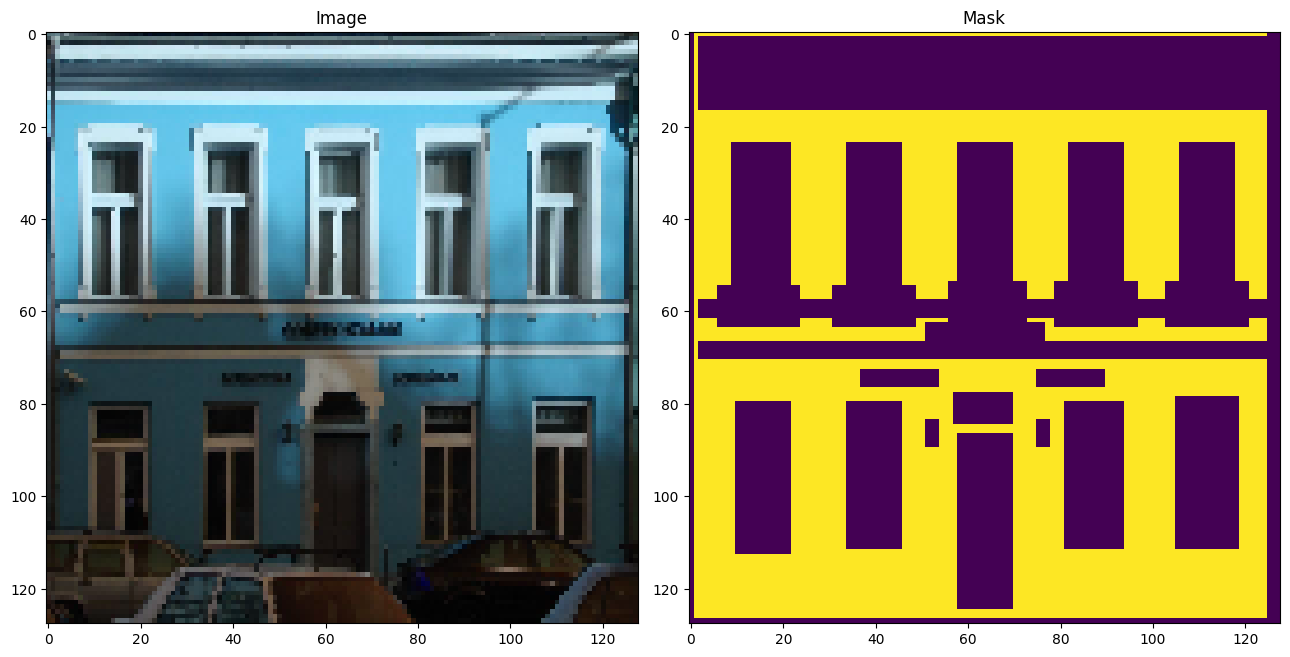

In [29]:
# выберем рандомно картинку и соответствующую ей маску
random_index = random.randint(0, len(X_train) - 1)
random_image = X_train[random_index]
random_mask = y_train[random_index]

# Display the image and its corresponding mask
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 7))
ax[0].imshow(random_image)
ax[0].set_title('Image')
ax[1].imshow(random_mask.squeeze())
ax[1].set_title('Mask')
plt.tight_layout()
plt.show();

## Формируем простейшую архитектуру U-Net
Попробуем обучить две модели с разными слоями и на разном количестве эпох.

In [30]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - (dice_coefficient(y_true, y_pred))

In [31]:
# Зададим константы
NUM_EPOCHS = 5
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
VALIDATION_STEPS = len(X_valid) // BATCH_SIZE

INPUT_SHAPE = (128, 128, 3)

### Model 1

In [32]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [33]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input(INPUT_SHAPE)

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)

    model = keras.models.Model(inputs, outputs)

    return model

In [34]:
model = UNet()

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer, loss="binary_crossentropy", metrics=[dice_coefficient, 'accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [35]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [48]:
%%time

# Define the model checkpoint callback
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5',
                                      monitor='val_dice_coefficient',
                                      mode='max',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      verbose=1)

steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
valid_steps = int(np.ceil(len(X_valid) / BATCH_SIZE))

# Train the model and save the best model checkpoint
basic_UNet = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=2,
                    epochs=50,
                    callbacks=[checkpoint_callback])

Epoch 1/50

Epoch 1: val_dice_coefficient improved from -inf to 0.00519, saving model to model_checkpoint.h5
5/5 - 23s - loss: 0.0383 - dice_coefficient: 0.0056 - accuracy: 0.5019 - val_loss: 0.0353 - val_dice_coefficient: 0.0052 - val_accuracy: 0.5027 - 23s/epoch - 5s/step
Epoch 2/50

Epoch 2: val_dice_coefficient improved from 0.00519 to 0.00728, saving model to model_checkpoint.h5
5/5 - 22s - loss: 0.0314 - dice_coefficient: 0.0054 - accuracy: 0.5918 - val_loss: 0.0355 - val_dice_coefficient: 0.0073 - val_accuracy: 0.5027 - 22s/epoch - 4s/step
Epoch 3/50

Epoch 3: val_dice_coefficient did not improve from 0.00728
5/5 - 23s - loss: 0.0327 - dice_coefficient: 0.0068 - accuracy: 0.5846 - val_loss: 0.0350 - val_dice_coefficient: 0.0064 - val_accuracy: 0.5027 - 23s/epoch - 5s/step
Epoch 4/50

Epoch 4: val_dice_coefficient did not improve from 0.00728
5/5 - 23s - loss: 0.0342 - dice_coefficient: 0.0062 - accuracy: 0.5469 - val_loss: 0.0357 - val_dice_coefficient: 0.0049 - val_accuracy: 0.

### Model 2

In [37]:
def unet2(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder path
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)

    # Decoder path
    up3 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv2)
    up3 = tf.keras.layers.concatenate([up3, conv1], axis=3)
    conv3 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up3)
    conv3 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv3)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer, loss="binary_crossentropy", metrics=[dice_coefficient, 'accuracy'])

    return model

In [38]:
unet2 = unet2(INPUT_SHAPE)
unet2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

In [35]:
%%time

steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
valid_steps = int(np.ceil(len(X_valid) / BATCH_SIZE))

unet2_model = unet2.fit_generator(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=2,
                    epochs=50)

<timed exec>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
5/5 - 26s - loss: 0.8337 - dice_coefficient: 0.0102 - accuracy: 0.0574 - val_loss: 0.7103 - val_dice_coefficient: 0.0109 - val_accuracy: 0.1984 - 26s/epoch - 5s/step
Epoch 2/50
5/5 - 24s - loss: 0.6532 - dice_coefficient: 0.0104 - accuracy: 0.3803 - val_loss: 0.5749 - val_dice_coefficient: 0.0108 - val_accuracy: 0.4841 - 24s/epoch - 5s/step
Epoch 3/50
5/5 - 24s - loss: 0.5392 - dice_coefficient: 0.0089 - accuracy: 0.6092 - val_loss: 0.4670 - val_dice_coefficient: 0.0106 - val_accuracy: 0.5022 - 24s/epoch - 5s/step
Epoch 4/50
5/5 - 23s - loss: 0.4132 - dice_coefficient: 0.0115 - accuracy: 0.5259 - val_loss: 0.3639 - val_dice_coefficient: 0.0104 - val_accuracy: 0.5026 - 23s/epoch - 5s/step
Epoch 5/50
5/5 - 24s - loss: 0.3050 - dice_coefficient: 0.0108 - accuracy: 0.5175 - val_loss: 0.2663 - val_dice_coefficient: 0.0101 - val_accuracy: 0.5027 - 24s/epoch - 5s/step
Epoch 6/50
5/5 - 24s - loss: 0.2224 - dice_coefficient: 0.0107 - accuracy: 0.4863 - val_loss: 0.1855 - val_dice_coe

### *Вывод:* Модель 1 обучилась лучше, выбираем ее для предсказаний.

In [64]:
# Display Dice coefficient
basic_UNet_accuracy = basic_UNet.history['accuracy']
print('Basic UNet accuracy:', basic_UNet_accuracy)

Basic UNet accuracy: [0.501879870891571, 0.591845691204071, 0.584606945514679, 0.5469258427619934, 0.5448628664016724, 0.5419352054595947, 0.5679484009742737, 0.6155070066452026, 0.6204793453216553, 0.6145243048667908, 0.5363627076148987, 0.614245593547821, 0.6144511103630066, 0.6025003790855408, 0.5690510869026184, 0.5611714720726013, 0.5388529300689697, 0.5541585087776184, 0.5715230107307434, 0.5726908445358276, 0.5872822999954224, 0.5654886960983276, 0.5490071773529053, 0.6047526001930237, 0.567401111125946, 0.6231160759925842, 0.5735453367233276, 0.5487467646598816, 0.5527120232582092, 0.5779439210891724, 0.6236775517463684, 0.5454935431480408, 0.503265380859375, 0.5624125003814697, 0.5383382439613342, 0.5917887091636658, 0.5010396242141724, 0.505523681640625, 0.4942891299724579, 0.5843282341957092, 0.5935038328170776, 0.5871541500091553, 0.500213623046875, 0.5521748661994934, 0.5818847417831421, 0.6414794921875, 0.5087137818336487, 0.6003357172012329, 0.5018839240074158, 0.5624532

In [49]:
# Display Dice coefficient
dice_coefficient = basic_UNet.history['dice_coefficient']
print('Dice coefficient:', dice_coefficient)

Dice coefficient: [0.005559077020734549, 0.005365136079490185, 0.006847103126347065, 0.0061738439835608006, 0.0058254702016711235, 0.007941062562167645, 0.005613439250737429, 0.005891492124646902, 0.006056888494640589, 0.005918491166085005, 0.007292383816093206, 0.006192230153828859, 0.0051361192017793655, 0.006170676555484533, 0.005949093960225582, 0.006894592195749283, 0.005623691715300083, 0.005896950140595436, 0.006468211766332388, 0.006632213946431875, 0.0055215382017195225, 0.0057823797687888145, 0.007178304251283407, 0.0051563759334385395, 0.0057192170061171055, 0.005479664541780949, 0.006979003548622131, 0.006217604037374258, 0.005298805423080921, 0.0069306595250964165, 0.004600204527378082, 0.00647729029878974, 0.006271354854106903, 0.0058856867253780365, 0.00696780439466238, 0.005470742005854845, 0.00736386701464653, 0.0056267594918608665, 0.0066412342712283134, 0.006966316141188145, 0.00568770244717598, 0.0068907355889678, 0.00598012562841177, 0.008032490499317646, 0.0042317

In [57]:
test = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\test"

### Please find testing part with an unseen test sample in ```load_predict.py``` file.